In [1]:
# import lib
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt 
import sys, os,cv2
from sklearn.utils import shuffle
from scipy.misc import imread,imresize
from keras.utils import to_categorical
plt.style.use('seaborn-white'); os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
np.random.seed(678); tf.set_random_seed(678)

Using TensorFlow backend.


In [2]:
# prepare STL 10
def read_all_images(path_to_data):
    """
    :param path_to_data: the file containing the binary images from the STL-10 dataset
    :return: an array containing all the images
    """

    with open(path_to_data, 'rb') as f:
        # read whole file in uint8 chunks
        everything = np.fromfile(f, dtype=np.uint8)

        # We force the data into 3x96x96 chunks, since the
        # images are stored in "column-major order", meaning
        # that "the first 96*96 values are the red channel,
        # the next 96*96 are green, and the last are blue."
        # The -1 is since the size of the pictures depends
        # on the input file, and this way numpy determines
        # the size on its own.

        images = np.reshape(everything, (-1, 3, 96, 96))

        # Now transpose the images into a standard image format
        # readable by, for example, matplotlib.imshow
        # You might want to comment this line or reverse the shuffle
        # if you will use a learning algorithm like CNN, since they like
        # their channels separated.
        images = np.transpose(images, (0, 3, 2, 1))
        return images
def read_labels(path_to_labels):
    """
    :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
    :return: an array containing the labels
    """
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        
        return labels

In [3]:
# activation functions
def tf_elu(x):     return tf.nn.elu(x)
def d_tf_elu(x):   return tf.cast(tf.greater(x,0),tf.float32) +  tf.exp(tf.cast(tf.less_equal(x,0),tf.float32) * x)
def tf_iden(x):    return x
def d_tf_iden(x):  return tf.ones_like(x)
def tf_softmax(x): return tf.nn.softmax(x)

class CNN():
    
    def __init__(self,k,inc,out,act=tf_elu,d_act=d_tf_elu):
        self.padding    = 'SAME'
        self.stride     = 1
        self.w          = tf.Variable(tf.random_normal([k,k,inc,out],stddev=0.05))
        self.m,self.v   = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.act,self.d_act = act,d_act
        
    def getw(self): return self.w
    
    def feedforward(self,input,stride=1,padding='SAME'):
        self.padding= padding; self.stride = stride
        self.input  = input
        self.layer  = tf.nn.conv2d(input,self.w,strides=[1,self.stride,self.stride,1],padding=self.padding) 
        self.layerA = self.act(self.layer)
        return self.layerA
    
    def backprop(self,gradient,iter_num):
        grad_part_1 = gradient 
        grad_part_2 = self.d_act(self.layer) 
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2

        grad     = tf.nn.conv2d_backprop_filter(input = grad_part_3,filter_sizes = self.w.shape,out_backprop = grad_middle,
            strides=[1,self.stride,self.stride,1],padding=self.padding
        )/batch_size

        grad_pass = tf.nn.conv2d_backprop_input(input_sizes = self.input.shape,filter= self.w,  out_backprop = grad_middle,
            strides=[1,self.stride,self.stride,1],padding=self.padding
        )

        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-tf.pow(beta1,iter_num))
        v_hat = self.v / (1-tf.pow(beta2,iter_num))
        update_w.append(tf.assign( self.w,self.w - learning_rate*( m_hat/(tf.sqrt(v_hat) + adam_e)   )))
        return grad_pass,update_w  
class tf_batch_norm_layer():
    
    def __init__(self,vector_shape,axis=None):
        self.moving_mean = tf.Variable(tf.zeros(shape=[1,1,1,vector_shape],dtype=tf.float32))
        self.moving_vari = tf.Variable(tf.zeros(shape=[1,1,1,vector_shape],dtype=tf.float32))
        self.axis        = (0,1,2)
        
    def feedforward(self,input,training_phase,eps = 1e-8):
        self.input = input
        self.input_size          = self.input.shape
        self.batch,self.h,self.w,self.c = self.input_size[0].value,self.input_size[1].value,self.input_size[2].value,self.input_size[3].value

        # Training Moving Average Mean         
        def training_fn():
            self.mean    = tf.reduce_mean(self.input,axis=self.axis ,keepdims=True)
            self.var     = tf.reduce_mean(tf.square(self.input-self.mean),axis=self.axis,keepdims=True)
            centered_data= (self.input - self.mean)/tf.sqrt(self.var + eps)
            
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean*0.9 + 0.1 * self.mean ))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari*0.9 + 0.1 * self.var  ))
            return centered_data,update_variable
        
        # Testing Moving Average Mean        
        def  testing_fn():
            centered_data   = (self.input - self.moving_mean)/tf.sqrt(self.moving_vari + eps)
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari))
            return centered_data,update_variable
        
        self.output,update_variable = tf.cond(training_phase,true_fn=training_fn,false_fn=testing_fn)
        return self.output,update_variable
    
    def backprop(self,grad,eps = 1e-8):
        change_parts = 1.0 /(self.batch * self.h * self.w)
        grad_sigma   = tf.reduce_sum( grad *  (self.input-self.mean)     ,axis=self.axis,keepdims=True) * -0.5 * (self.var+eps) ** -1.5
        grad_mean    = tf.reduce_sum( grad *  (-1./tf.sqrt(self.var+eps)),axis=self.axis,keepdims=True) + grad_sigma * change_parts * 2.0 * tf.reduce_sum((self.input-self.mean),axis=self.axis,keepdims=True) * -1
        grad_x       = grad * 1/(tf.sqrt(self.var+eps)) + grad_sigma * change_parts * 2.0 * (self.input-self.mean) + grad_mean * change_parts
        return grad_x
class tf_layer_norm_layer():
    
    def __init__(self,vector_shape):
        self.moving_mean = tf.Variable(tf.zeros(shape=[vector_shape,1,1,1],dtype=tf.float32))
        self.moving_vari = tf.Variable(tf.zeros(shape=[vector_shape,1,1,1],dtype=tf.float32))
        self.axis        = (1,2,3)
        
    def feedforward(self,input,training_phase=True,eps = 1e-8):
        self.input = input
        self.input_size          = self.input.shape
        self.batch,self.h,self.w,self.c = self.input_size[0].value,self.input_size[1].value,self.input_size[2].value,self.input_size[3].value

        # Training Moving Average Mean         
        def training_fn():
            self.mean    = tf.reduce_mean(self.input,axis=self.axis ,keepdims=True)
            self.var     = tf.reduce_mean(tf.square(self.input-self.mean),axis=self.axis,keepdims=True)
            centered_data= (self.input - self.mean)/tf.sqrt(self.var + eps)
            
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean*0.9 + 0.1 * self.mean ))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari*0.9 + 0.1 * self.var  ))
            return centered_data,update_variable
        
        # Testing Moving Average Mean        
        def  testing_fn():
            centered_data   = (self.input - self.moving_mean)/tf.sqrt(self.moving_vari + eps)
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari))
            return centered_data,update_variable
        
        self.output,update_variable = tf.cond(training_phase,true_fn=training_fn,false_fn=testing_fn)
        return self.output,update_variable
    
    def backprop(self,grad,eps = 1e-8):
        change_parts = 1.0 /(self.h * self.w * self.c)
        grad_sigma   = tf.reduce_sum( grad *  (self.input-self.mean)     ,axis=self.axis,keepdims=True) * -0.5 * (self.var+eps) ** -1.5
        grad_mean    = tf.reduce_sum( grad *  (-1./tf.sqrt(self.var+eps)),axis=self.axis,keepdims=True) + grad_sigma * change_parts * 2.0 * tf.reduce_sum((self.input-self.mean),axis=self.axis,keepdims=True) * -1
        grad_x       = grad * 1/(tf.sqrt(self.var+eps)) + grad_sigma * change_parts * 2.0 * (self.input-self.mean) + grad_mean * change_parts
        return grad_x

In [4]:
! start .

In [5]:
# load the data
x_train,y_train = read_all_images('../Dataset/STL10/stl10_binary/train_x.bin'),read_labels('../Dataset/STL10/stl10_binary/train_y.bin')
x_test,y_test   = read_all_images('../Dataset/STL10/stl10_binary/test_x.bin'),read_labels('../Dataset/STL10/stl10_binary/test_y.bin')

y_train = to_categorical(y_train-1)
y_test  = to_categorical(y_test-1)

x_train = (x_train-x_train.min((1,2),keepdims=True))/(x_train.max((1,2),keepdims=True)-x_train.min((1,2),keepdims=True))
x_train = (x_train-x_train.mean((1,2),keepdims=True))/(x_train.std((1,2),keepdims=True))
x_test = (x_test-x_test.min((1,2),keepdims=True))/(x_test.max((1,2),keepdims=True)-x_test.min((1,2),keepdims=True))
x_test = (x_test-x_test.mean((1,2),keepdims=True))/(x_test.std((1,2),keepdims=True))

print(x_train.shape,y_train.shape,x_train.min(),x_train.max())
print(x_test.shape,y_test.shape,x_test.min(),x_test.max())

(5000, 96, 96, 3) (5000, 10) -11.595098265964817 15.777090090299724
(8000, 96, 96, 3) (8000, 10) -10.553357891447178 22.92614277238906


In [6]:
# declare hyper parameter
learning_rate = 0.0008 ; beta1 = 0.9; beta2 = 0.999; adam_e = 1e-8
num_epoch     = 30    ; batch_size = 50 ; print_size = 1; 
channel_sizes = 96 

In [6]:
# declare layer
avg_acc_train = 0; avg_acc_test  = 0; train_acc = [];test_acc = []
avg_lss_train = 0; avg_lss_test  = 0; train_lss = [];test_lss = []

l1   = CNN(3,3,channel_sizes)
l2   = CNN(3,channel_sizes,channel_sizes)
l3   = CNN(3,channel_sizes,channel_sizes)

l4   = CNN(3,channel_sizes,channel_sizes)
l5   = CNN(3,channel_sizes,channel_sizes)
l6   = CNN(3,channel_sizes,channel_sizes)

l7   = CNN(3,channel_sizes,channel_sizes)
l8   = CNN(1,channel_sizes,channel_sizes)
l9   = CNN(1,channel_sizes,10)

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
# graph
x = tf.placeholder(shape=[batch_size,96,96,3],dtype=tf.float32)
y = tf.placeholder(shape=[batch_size,10],     dtype=tf.float32)
is_train = tf.placeholder_with_default(True,())
iter_num = tf.placeholder_with_default(1.0,())

layer1  = l1. feedforward(x,padding='VALID',stride=2)    
layer2  = l2.feedforward(layer1,padding='VALID') 
layer3  = l3.feedforward(layer2,padding='VALID',stride=2); 

layer4  = l4.feedforward(layer3,padding='VALID');      
layer5  = l5.feedforward(layer4,padding='VALID');      
layer6  = l6.feedforward(layer5,padding='VALID',stride=2)

layer7  = l7.feedforward(layer6,padding='VALID')
layer8  = l8.feedforward(layer7)
layer9  = l9.feedforward(layer8)

final_global = tf.reduce_mean(layer9,[1,2])
final_soft   = tf_softmax(final_global) ; 
cost         = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=final_global,labels=y))
accuracy     = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(final_soft, 1), tf.argmax(y, 1)),tf.float32) )

gradient     = tf.tile((final_soft-y)[:,None,None,:],(1,6,6,1))

grad9, grad9_up  = l9. backprop(gradient,iter_num)
grad8, grad8_up  = l8. backprop(grad9,iter_num)
grad7, grad7_up  = l7. backprop(grad8,iter_num)

grad6, grad6_up  = l6. backprop(grad7,iter_num)
grad5, grad5_up  = l5. backprop(grad6,iter_num)
grad4, grad4_up  = l4. backprop(grad5,iter_num)

grad3,grad3_up   = l3. backprop(grad4,iter_num)
grad2,grad2_up   = l2. backprop(grad3,iter_num)
grad1,grad1_up   = l1. backprop(grad2,iter_num)

grad_update =  grad9_up + grad8_up + grad7_up +\
               grad6_up + grad5_up + grad4_up +\
               grad3_up + grad2_up + grad1_up 

In [7]:
# start the session
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
sess.run(tf.global_variables_initializer())

In [9]:
# start the training 
for iter in range(1,num_epoch+1):
    for current_batch_index in range(0,len(x_train),batch_size):
        current_data  = x_train[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = y_train[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,cost,grad_update],feed_dict={x:current_data,y:current_label,iter_num:iter})
        sys.stdout.write('Current Iter : '+str(iter)+'/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(x_train)) + ' acc : '+str(sess_results[0]) + ' cost : '+str(sess_results[1])+ '\r')
        sys.stdout.flush(); 
        avg_acc_train = avg_acc_train + sess_results[0]
        avg_lss_train = avg_lss_train + sess_results[1]
    for current_batch_index in range(0,len(x_test), batch_size):
        current_data  = x_test[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        current_label = y_test[current_batch_index:current_batch_index+batch_size].astype(np.float32)
        sess_results  = sess.run([accuracy,cost],feed_dict={x:current_data,y:current_label,is_train:False})
        sys.stdout.write('Current Iter : '+str(iter)+'/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(x_test)) + ' acc : '+str(sess_results[0]) + ' cost : '+str(sess_results[1])+ '\r')
        sys.stdout.flush(); 
        avg_acc_test = avg_acc_test + sess_results[0]
        avg_lss_test = avg_lss_test + sess_results[1]
    # ======================== print reset ========================  
    print("Current: "+ str(iter) + 
          "\tTrain Acc: "  + str(avg_acc_train/(len(x_train)/batch_size)) + 
          "\tTrain Cost: " + str(avg_lss_train/(len(x_train)/batch_size)) + 
          "\tTest Acc: "   + str(avg_acc_test/(len(x_test)/batch_size)) + 
          "\tTest Cost: "  + str(avg_lss_test/(len(x_test)/batch_size)) + 
          "\tLR: " + str(learning_rate) )
    avg_acc_train   = 0 ; avg_acc_test  = 0 ; avg_lss_train = 0 ; avg_lss_test  = 0
    x_train,y_train = shuffle(x_train,y_train); x_test,y_test   = shuffle(x_test,y_test)

Current: 1	Train Acc: 0.12219999950379133	Train Cost: 2.276678659915924	Test Acc: 0.15237499957438558	Test Cost: 2.2773143887519836	LR: 0.0008
Current: 2	Train Acc: 0.20780000001192092	Train Cost: 2.152440881729126	Test Acc: 0.25824999948963523	Test Cost: 2.023808221518993	LR: 0.0008
Current: 3	Train Acc: 0.2935999993979931	Train Cost: 1.9185413479804994	Test Acc: 0.35125000067055223	Test Cost: 1.7913942433893681	LR: 0.0008
Current: 4	Train Acc: 0.3696000011265278	Train Cost: 1.6899959290027617	Test Acc: 0.3793750010430813	Test Cost: 1.6424052387475967	LR: 0.0008
Current: 5	Train Acc: 0.4208000001311302	Train Cost: 1.5723451638221742	Test Acc: 0.4302499983459711	Test Cost: 1.5321230098605156	LR: 0.0008
Current: 6	Train Acc: 0.4697999969124794	Train Cost: 1.441460303068161	Test Acc: 0.45399999879300595	Test Cost: 1.4731350645422936	LR: 0.0008
Current: 7	Train Acc: 0.49679999858140944	Train Cost: 1.3626715815067292	Test Acc: 0.4666249996051192	Test Cost: 1.4415630236268044	LR: 0.0008
Cur

-0.00081823836 0.05022159
0.040338773


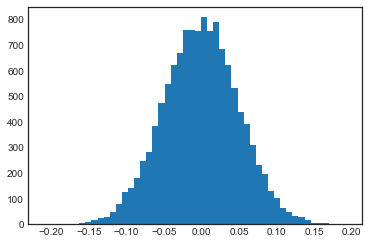

In [27]:
# see 
temp = tf.random_normal([3,3,25,55],stddev=0.05)
temp_abs_mean = tf.reduce_mean(tf.abs(temp))
temp_between1  = tf.where(-temp_abs_mean<=temp,tf.ones_like(temp),tf.zeros_like(temp))
temp_between2  = tf.where(temp<=temp_abs_mean,tf.ones_like(temp),tf.zeros_like(temp))

temp = temp.eval()
temp_abs_mean = temp_abs_mean.eval()
print(temp.mean(),temp.std())
print(temp_abs_mean)

plt.hist(temp.flatten(),bins=50); plt.show()
